## Hierarchical topic model

In [ ]:
using Distributions, StatsFuns, Gadfly, StatsBase, DataFrames
import Lazy.@>, Lazy.@>>, Lazy.@as
include("/home/seth/code/LogisticTopicRegression/PosteriorSummStats.jl");
include("/home/seth/code/LogisticTopicRegression/topicllm.jl");

In [97]:
σ_μ = 1.0;
σ = 0.5;

n = 100;
nd = repeat([25],inner=[n]);
K = 5;
y = Vector{Array{Int64,2}}(n);
μ = randn(K)*σ_μ;
softmax(μ)

5-element Array{Float64,1}:
 0.0890125
 0.426661 
 0.269299 
 0.0193374
 0.19569  

In [98]:
θ = linspace(0.1,K*2,K).^2;
η = Array{Float64}(K,n);
nk = Array{Int64}(K,n);
for i in 1:n
    η[:,i] = randn(K).*σ .+ μ;
    nk[:,i] = rand(Multinomial(nd[i],softmax(η[:,i])));
    y[i] = vcat(map( (mu,mu2,nki) -> hcat(rand(Poisson(mu),nki),rand(Poisson(mu2),nki)),θ,θ[K:-1:1],nk[:,i])...)';
end

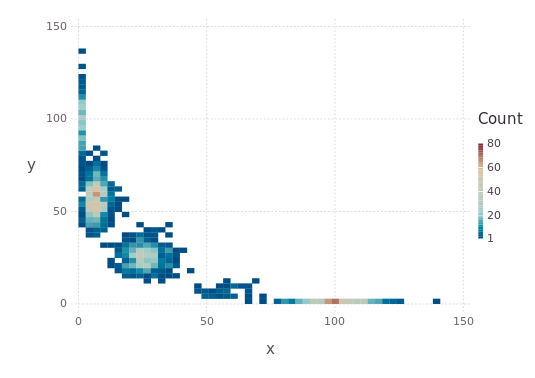

In [99]:
plot(x=hcat(y...)[1,:]',y=hcat(y...)[2,:]',Geom.histogram2d(xbincount=50,ybincount=50))

In [168]:
a = 0.1;
b = 0.1;
pss = VectorPosterior([PoissonPosterior(a,b),PoissonPosterior(a,b)]);
@time fit = topiclmm(y,pss,K,5000,2);
ns = length(fit[:τ]);

167.057877 seconds (865.93 M allocations: 37.098 GB, 4.50% gc time)


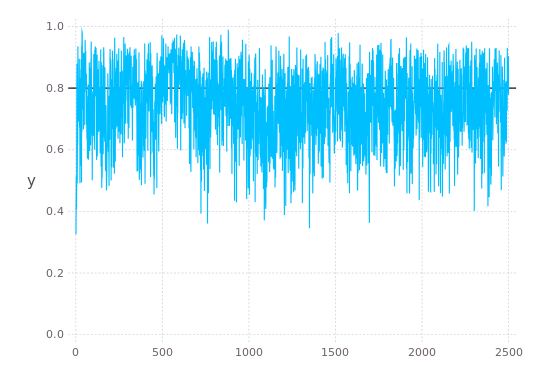

In [169]:
plot(y=fit[:τ]./(fit[:τ]+1),yintercept=[(σ_μ^2)/(σ_μ^2 + σ^2)],Geom.line,Geom.hline(color=colorant"black"))

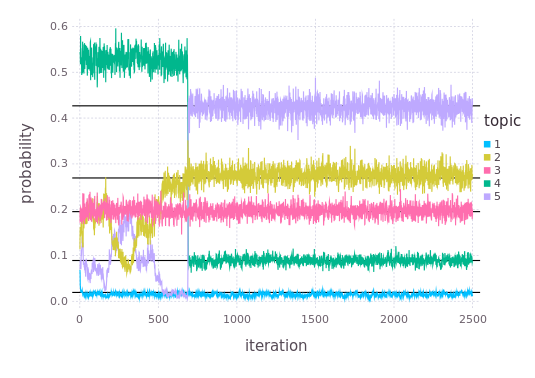

In [170]:
mudat = DataFrame(probability = mapslices(softmax,fit[:μ],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(mudat,x="iteration",y="probability",color="topic",yintercept=softmax(μ),
Geom.line,Geom.hline(color=colorant"black"))

In [171]:
warmup = 1000;

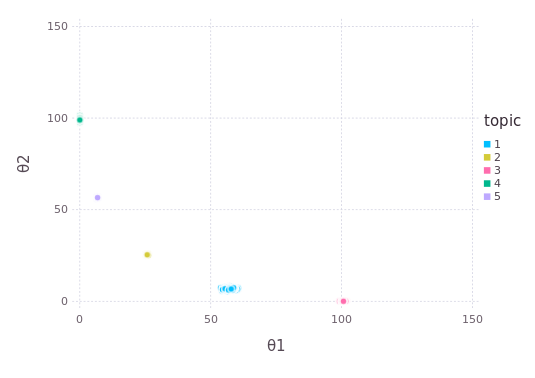

In [175]:
θpost1 = Float64[rand(topicpd(fit[:topic][i][j]))[1] for i=(warmup+1):ns, j=1:K];
θpost2 = Float64[rand(topicpd(fit[:topic][i][j]))[2] for i=(warmup+1):ns, j=1:K];
θdat = DataFrame(θ1 = θpost1[:],θ2 = θpost2[:],topic=repeat(map(string,1:K),inner=[ns-warmup]),iteration=repeat(collect(1:(ns-warmup)),outer=[K]))
plot(θdat,x="θ1",y="θ2",color="topic",Geom.point)

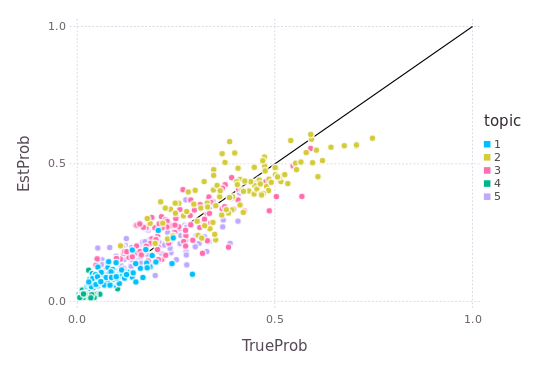

In [176]:
ord = sortperm(vec(mean(θpost1,1)));
phat = @> mapslices(softmax,fit[:η][:,:,(warmup+1):ns],1) mean(3) getindex(ord,:);
p = mapslices(softmax,η,1);
pdat = DataFrame(TrueProb=p[:],EstProb=phat[:],RawProb=nk[:]./nd[1],topic=repeat(map(string,1:K),outer=[n]))
plot(layer(pdat,x="TrueProb",y="EstProb",color="topic",Geom.point),
layer(x=[0.,1],y=[0.,1],Theme(default_color=colorant"black"),Geom.line))

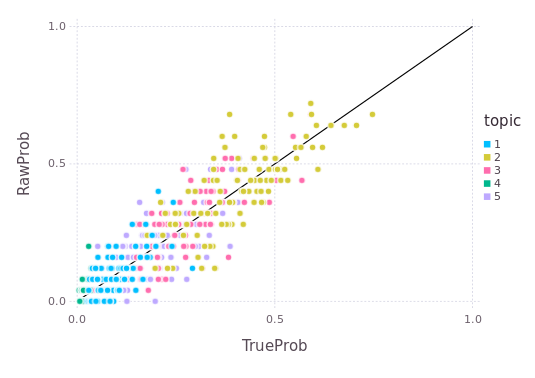

In [177]:
plot(layer(pdat,x="TrueProb",y="RawProb",color="topic",Geom.point),
layer(x=[0.,1],y=[0.,1],Theme(default_color=colorant"black"),Geom.line))

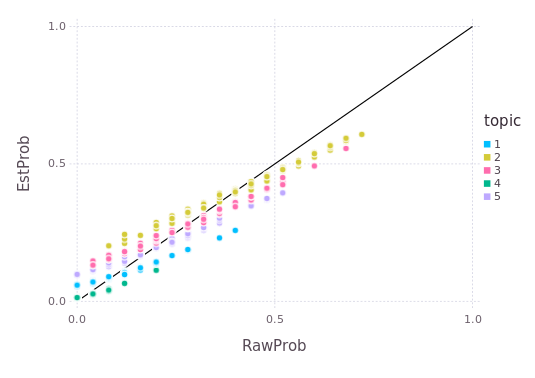

In [178]:
plot(layer(pdat,x="RawProb",y="EstProb",color="topic",Geom.point),
layer(x=[0.,1],y=[0.,1],Theme(default_color=colorant"black"),Geom.line))

## Model comparison

In [179]:
fit1p = topiclmm(y,pss,K+1,5000,2);
fit1m = topiclmm(y,pss,K-1,5000,2);

In [180]:
lp = lppd(fit,y);
lp1p = lppd(fit1p,y);
lp1m = lppd(fit1m,y);

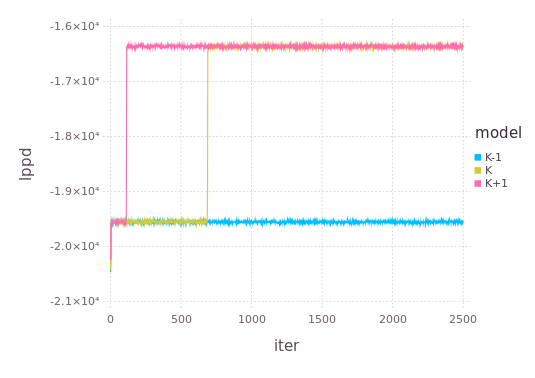

In [181]:
lpdat = DataFrame(lppd=vcat(sum(hcat(lp1m...),2),sum(hcat(lp...),2),sum(hcat(lp1p...),2))[:],
model=repeat(["K-1","K","K+1"],inner=[ns]),iter=repeat(collect(1:ns),outer=[3]));
plot(lpdat,x="iter",y="lppd",color="model",Geom.line)

In [182]:
using RCall
rcopy("library(loo)");
globalEnv[:lp] = hcat(lp...)[(warmup+1):ns,:];
globalEnv[:lp1p] = hcat(lp1p...)[(warmup+1):ns,:];
globalEnv[:lp1m] = hcat(lp1m...)[(warmup+1):ns,:];

In [183]:
lploo = rcopy("loo(lp)");
lp1ploo = rcopy("loo(lp1p)");
lp1mloo = rcopy("loo(lp1m)");

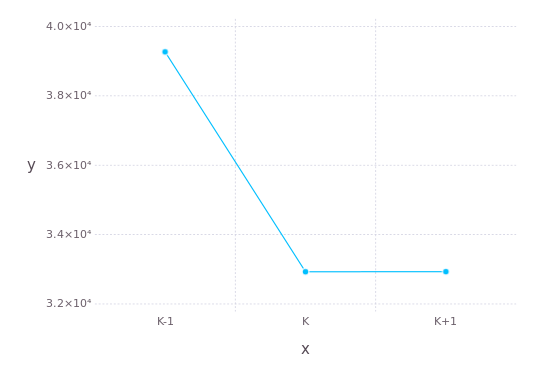

In [184]:
plot(y=[lp1mloo[:looic],lploo[:looic],lp1ploo[:looic]],x=["K-1","K","K+1"],Geom.point,Geom.line)